In [1]:
import warnings
warnings.filterwarnings('ignore')

import sys
import math
import numpy as np
import copy
import time
import pickle
from random import seed, shuffle, sample

from sklearn.preprocessing import StandardScaler
from aif360.datasets import AdultDataset, CompasDataset, GermanDataset, BankDataset, StandardDataset

import matplotlib
import matplotlib.pyplot as plt
import os

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

%matplotlib inline

`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_df

In [3]:
sys.path.append('../baselines/iFair/')
sys.path.append('../baselines/LFR/')
sys.path.append('../baselines/PFR/')
sys.path.append('../iFlipper/')

from iflipper import iFlipper
from aif360.algorithms.preprocessing import LFR
from iFair import iFair
from PFR import PFR, similarity_pfr, estimate_dim

from cplex_solver import CPLEX_Solver
from greedy import Greedy
from gradient import Gradient

from utils import generate_sim_matrix
from model import Model

# Load fairness dataset from AIF360 and define variables
### 1. Dataset = COMPAS, AdultCensus, Credit
### 2. Similarity matrix = knn, threshold
### 3. ML model = LogisticRegression, RandomForest, NeuralNetwork

In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import copy
import falconn

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import roc_auc_score
from aif360.metrics import ClassificationMetric


def measure_error(label, edge, w_edge):
    total_error = np.sum(w_edge * abs(label[edge[:,0]]-label[edge[:,1]]))

    return total_error

def measure_consistency(model, data, edge, w_edge):

    y_hat = model.predict(data)
    
    total_error = measure_error(y_hat, edge, w_edge)
    num_similar_pairs = len(edge)
    
    consistency_score = 1 - total_error / num_similar_pairs
    return consistency_score

def generate_sim_matrix(data, similarity_matrix, similarity_params):
    n, d = data.shape
    w_sim = np.zeros((n, n))

    params = falconn.get_default_parameters(n, d)
    params.lsh_family = falconn.LSHFamily.Hyperplane

    params.k = similarity_params["num_hash"]
    params.l = similarity_params["num_table"]

    table = falconn.LSHIndex(params)
    table.setup(data)
    qo = table.construct_query_object()
    
    edge = []
    for i in range(data.shape[0]):
        if similarity_matrix == "knn":
            indices = qo.find_k_nearest_neighbors(data[i], similarity_params["k"]+1)
        elif similarity_matrix == "threshold":
            indices = qo.find_near_neighbors(data[i], similarity_params["threshold"]**2)

        distances = np.squeeze(euclidean_distances([data[i]], data[indices]))
        w_sim[i, indices] = np.exp(-1 * similarity_params["theta"] * distances)
        w_sim[indices, i] = np.exp(-1 * similarity_params["theta"] * distances)
        w_sim[i][i] = 0

    temp = np.argwhere(w_sim > 0)
    edge = np.squeeze(temp[np.argwhere(temp[:, 0] < temp[:, 1])])
    w_edge = w_sim[edge[:,0], edge[:,1]]

    return w_sim, edge, w_edge

def performance_func(model, data, label, edge, w_edge):

    accuracy = model.score(data, label)
    consistency_score = measure_consistency(model, data, edge, w_edge)
    
    return accuracy, consistency_score

def generate_original_sim_matrix(data, similarity_matrix, similarity_params):
    n, d = data.shape
    w_sim = np.zeros((n, n))
    
    for i in range(data.shape[0]):
        distances = np.squeeze(euclidean_distances([data[i]], data))
        if similarity_matrix == "knn":
            idx = np.argsort(distances)[:similarity_params["k"]+1]
        elif similarity_matrix == "threshold":
            idx = distances < similarity_params["threshold"]

        w_sim[i, idx] = 1
        w_sim[idx, i] = 1
        w_sim[i][i] = 0
        
    temp = np.argwhere(w_sim > 0)
    edge = np.squeeze(temp[np.argwhere(temp[:, 0] < temp[:, 1])])
    w_edge = w_sim[edge[:,0], edge[:,1]]
                
    return w_sim, edge, w_edge

In [5]:
import math
import numpy as np
import matplotlib.pyplot as plt # for plotting stuff
from random import seed, shuffle
from scipy.stats import multivariate_normal # generating synthetic data
SEED = 1122334455
seed(SEED) # set the random seed so that the random permutations can be reproduced again
np.random.seed(SEED)

def generate_synthetic_data(n_samples1, n_samples2, plot_data=False):

    """
        Code for generating the synthetic data.
        We will have two non-sensitive features and one sensitive feature.
        A sensitive feature value of 0.0 means the example is considered to be in protected group (e.g., female) and 1.0 means it's in non-protected group (e.g., male).
    """

    # n_samples = 1000 # generate these many data points per class
    disc_factor = math.pi / 4.0 # this variable determines the initial discrimination in the data -- decraese it to generate more discrimination

    def gen_gaussian(mean_in, cov_in, class_label, n_samples):
        nv = multivariate_normal(mean = mean_in, cov = cov_in)
        X = nv.rvs(n_samples)
        y = np.ones(n_samples, dtype=float) * class_label
        return nv,X,y

    """ Generate the non-sensitive features randomly """
    # We will generate one gaussian cluster for each class
    mu1, sigma1 = [2, 2], [[5, 1], [1, 5]]
    mu2, sigma2 = [-2,-2], [[10, 1], [1, 3]]
    nv1, X1, y1 = gen_gaussian(mu1, sigma1, 1, n_samples1) # positive class
    nv2, X2, y2 = gen_gaussian(mu2, sigma2, 0, n_samples2) # negative class

    # join the posisitve and negative class clusters
    X = np.vstack((X1, X2))
    y = np.hstack((y1, y2))

    # shuffle the data
    perm = np.arange(0,n_samples1+n_samples2)
    shuffle(perm)
    X = X[perm]
    y = y[perm]
    
    rotation_mult = np.array([[math.cos(disc_factor), -math.sin(disc_factor)], [math.sin(disc_factor), math.cos(disc_factor)]])
    X_aux = np.dot(X, rotation_mult)


    return X,y

def plot_data(X, y):

    plt.figure(figsize=(12, 8))
    num_to_draw = 200 # we will only draw a small number of points to avoid clutter
    # x_draw = X[:num_to_draw]
    # y_draw = y[:num_to_draw]

    plt.scatter(X[y==1.0][:, -2], X[y==1.0][:, -1], color='green', marker='o', s=50, linewidth=2)
    plt.scatter(X[y==0.0][:, -2], X[y==0.0][:, -1], color='red', marker='x', s=50, linewidth=2)

    # X_s_0 = x_draw[x_control_draw == 0.0]
    # X_s_1 = x_draw[x_control_draw == 1.0]
    # y_s_0 = y_draw[x_control_draw == 0.0]
    # y_s_1 = y_draw[x_control_draw == 1.0]

    # plt.scatter(X_s_0[y_s_0==1.0][:, 0], X_s_0[y_s_0==1.0][:, 1], color='green', marker='x', s=50, linewidth=1.5, label= "Prot. +ve")
    # plt.scatter(X_s_0[y_s_0==-0.0][:, 0], X_s_0[y_s_0==-0.0][:, 1], color='red', marker='x', s=50, linewidth=1.5, label = "Prot. -ve")
    # plt.scatter(X_s_1[y_s_1==1.0][:, 0], X_s_1[y_s_1==1.0][:, 1], color='green', marker='o', facecolors='none', s=50, label = "Non-prot. +ve")
    # plt.scatter(X_s_1[y_s_1==-0.0][:, 0], X_s_1[y_s_1==-0.0][:, 1], color='red', marker='o', facecolors='none', s=50, label = "Non-prot. -ve")



    
    # plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off') # dont need the ticks to see the data distribution
    # plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
    plt.legend(loc=2, fontsize=15)
    # plt.xlim((-15,10))
    # plt.ylim((-10,15))
    # plt.savefig("img/data.png")
    plt.show()

In [6]:
num_examples1, num_examples2 = 2000, 1000
X, Y = generate_synthetic_data(num_examples1, num_examples2, True)

num_train, num_test, num_val = 0.5, 0.3, 0.2

x_train, x_test, x_val = X[:int(num_train*len(Y))], X[int(num_train*len(Y)):int(num_train*len(Y))+int(num_test*len(Y))], X[int(num_train*len(Y))+int(num_test*len(Y)):]
y_train, y_test, y_val = Y[:int(num_train*len(Y))], Y[int(num_train*len(Y)):int(num_train*len(Y))+int(num_test*len(Y))], Y[int(num_train*len(Y))+int(num_test*len(Y)):]

# print(x_train.shape, x_test.shape, x_val.shape)
# print(y_train.shape, y_test.shape, y_val.shape)

# plot_data(X, Y)

In [7]:
test_accuracy, test_consistency_score, runtime = dict(), dict(), dict()


similarity_matrix = "knn" # threshold
model_type = "LogisticRegression" # RandomForest, NeuralNetwork

similarity_params = dict()
similarity_params["num_hash"], similarity_params["num_table"], similarity_params["theta"] = 1, 10, 0.05
similarity_params["k"], similarity_params["threshold"] = 20, 3

size_arr = [100, 500, 1000, 5000, 10000, 25000, 50000, 75000, 100000, 200000]

for method in size_arr:
    
    size = 2 * method
    num_examples1, num_examples2 = int(0.75 * size), int(0.25 * size)

    X, Y = generate_synthetic_data(num_examples1, num_examples2, True)

    num_train, num_test, num_val = 0.5, 0.3, 0.2

    x_train, x_test, x_val = X[:int(num_train*len(Y))], X[int(num_train*len(Y)):int(num_train*len(Y))+int(num_test*len(Y))], X[int(num_train*len(Y))+int(num_test*len(Y)):]
    y_train, y_test, y_val = Y[:int(num_train*len(Y))], Y[int(num_train*len(Y)):int(num_train*len(Y))+int(num_test*len(Y))], Y[int(num_train*len(Y))+int(num_test*len(Y)):]

    w_train, edge_train, w_edge_train = generate_original_sim_matrix(x_train, similarity_matrix, similarity_params)
    w_test, edge_test, w_edge_test = generate_original_sim_matrix(x_test, similarity_matrix, similarity_params)
    w_val, edge_val, w_edge_val = generate_original_sim_matrix(x_val, similarity_matrix, similarity_params)

    print(x_train.shape, x_test.shape, x_val.shape)
    print(len(w_train[w_train > 0]), len(edge_train), measure_error(y_train, edge_train, w_edge_train))

    model = Model(model_type, x_train, y_train, edge_train, w_edge_train, x_test, y_test, edge_test, w_edge_test, x_val, y_val)
    train_performance, test_performance = model.train()

    print("============================")
    print(f"Test Accuracy: {test_performance[0]:.5f}") 
    print(f"Test Consistency Score: {test_performance[1]:.5f}")

    init_error = measure_error(y_train, edge_train, w_edge_train)
    print(f"Initial amount of total error: {init_error:.1f}")

    for i in [0.2]:
        m = (init_error * i)
            
        start = time.time()
        IFLIP = iFlipper(y_train, w_train, edge_train, w_edge_train)
        flipped_label = IFLIP.transform(m)
        elapsed_time = time.time() - start

        model = Model(model_type, x_train, flipped_label, edge_train, w_edge_train, x_test, y_test, edge_test, w_edge_test, x_val, y_val)
        train_performance, test_performance = model.train()

        print("============================")
        print(f"Total error limit: {m:.1f}")
        print(f"Total error: {measure_error(flipped_label, edge_train, w_edge_train):.1f}")
        print(f"Number of flips: {np.sum(y_train != flipped_label)}")
        print(f"Test Accuracy: {test_performance[0]:.5f}") 
        print(f"Test Consistency Score: {test_performance[1]:.5f}")
        print(f"Runtime (sec): {elapsed_time:.5f}")

        test_accuracy[method] = test_performance[0]
        test_consistency_score[method] = test_performance[1]
        runtime[method] = elapsed_time
        # print(np.sum(flipped_label == 1), np.sum(flipped_label == 0))
        # plot_data(x_train, flipped_label)

(100, 2) (60, 2) (40, 2)
2514 1257 229.0
Test Accuracy: 0.98333
Test Consistency Score: 0.83943
Initial amount of total error: 229.0
Total error limit: 45.8
Total error: 38.0
Number of flips: 25
Test Accuracy: 0.73333
Test Consistency Score: 0.97389
Runtime (sec): 0.22204
(500, 2) (300, 2) (200, 2)
11954 5977 918.0
Test Accuracy: 0.91000
Test Consistency Score: 0.94638
Initial amount of total error: 918.0
Total error limit: 183.6
Total error: 178.0
Number of flips: 104
Test Accuracy: 0.72667
Test Consistency Score: 0.99447
Runtime (sec): 2.58749
(1000, 2) (600, 2) (400, 2)
23640 11820 1697.0
Test Accuracy: 0.88833
Test Consistency Score: 0.95932
Initial amount of total error: 1697.0
Total error limit: 339.4
Total error: 339.0
Number of flips: 82
Test Accuracy: 0.88667
Test Consistency Score: 0.95890
Runtime (sec): 3.30802
(5000, 2) (3000, 2) (2000, 2)
113606 56803 8334.0
Test Accuracy: 0.89033
Test Consistency Score: 0.98247
Initial amount of total error: 8334.0
Total error limit: 1666

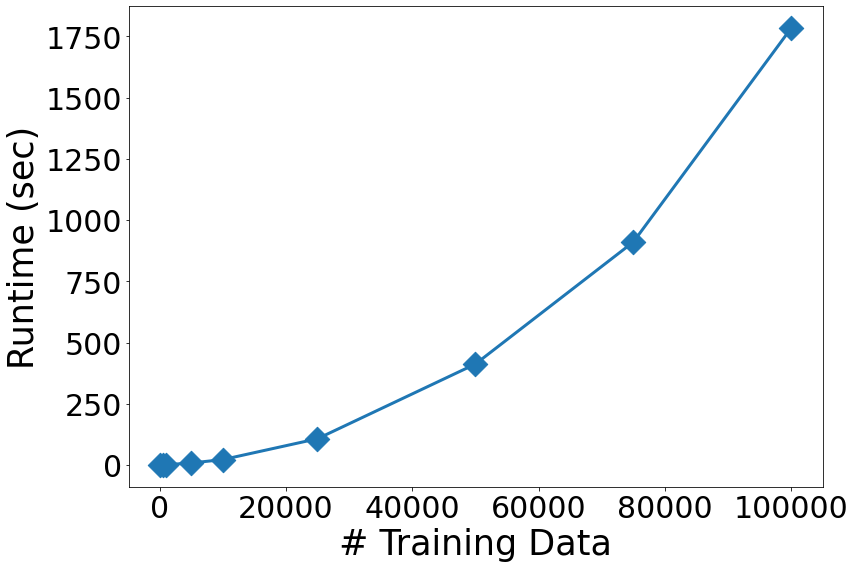

In [ ]:
runtime_arr = []
for key in runtime:
    runtime_arr.append(runtime[key])

plt.figure(figsize=(12, 8))
plt.scatter(size_arr, runtime_arr, s=300, marker='D')
plt.plot(size_arr, runtime_arr, linewidth=3)

plt.tick_params(labelsize=30)
plt.ylabel("Runtime (sec)", fontsize=35)
plt.xlabel("# Training Data", fontsize=35)

plt.tight_layout()
# plt.savefig(f"synthetic.pdf")

plt.show()

In [ ]:
list(size_arr)

[100, 500, 1000, 5000, 10000, 25000, 50000, 75000, 100000]

In [ ]:
list(runtime_arr)

[0.17881441116333008,
 0.5220553874969482,
 1.2718133926391602,
 8.25816011428833,
 22.059938430786133,
 107.28801345825195,
 412.0763986110687,
 910.0880081653595,
 1783.0952820777893]